# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [58]:
import requests
import tarfile
import os

# URL of the CIFAR-10 dataset
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

# Define the local filename to save the file
filename = 'cifar-10-python.tar.gz'

# Download the file
print("Downloading CIFAR-10 dataset...")
response = requests.get(url, stream=True)

# Save the downloaded file
with open(filename, 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:  # filter out keep-alive new chunks
            file.write(chunk)

print("Download complete.")

# Check if the file is downloaded
if os.path.exists(filename):
    # Extract the file
    print("Extracting the dataset...")
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall(path='cifar-10-batches-py')  # Specify extraction directory
    print("Extraction complete.")
else:
    print("File not found.")

# Optional: Clean up by removing the tar.gz file if you don't need it anymore
# os.remove(filename)

print("CIFAR-10 dataset is ready to use.")



Download complete.
Extracting the dataset...
Extraction complete.
CIFAR-10 dataset is ready to use.


In [67]:
import pickle

# Function to unpickle a file
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# Load label names from the batches.meta file
meta_file_path = './cifar-10-batches-py/batches.meta'
meta_data = unpickle(meta_file_path)
label_names = meta_data[b'label_names']

# Decode byte strings to normal strings
label_names = [label.decode('utf-8') for label in label_names]

# Print label names
print("CIFAR-10 Label Names:")
print(label_names)


CIFAR-10 Label Names:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [69]:
import numpy as np

# Define file paths for data batches
batch_files = [
    './cifar-10-batches-py/data_batch_1',
    './cifar-10-batches-py/data_batch_2',
    './cifar-10-batches-py/data_batch_3',
    './cifar-10-batches-py/data_batch_4',
    './cifar-10-batches-py/data_batch_5'
]

# Initialize empty lists to store data and labels
train_data = []
train_labels = []

# Load data from each batch file
for batch_file in batch_files:
    batch_data = unpickle(batch_file)
    train_data.append(batch_data[b'data'])
    train_labels.extend(batch_data[b'labels'])

# Convert data and labels to numpy arrays
train_data = np.concatenate(train_data)
train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape and transpose to (num_samples, 32, 32, 3)
train_labels = np.array(train_labels)

# Print shape of training data and labels
print("Training Data Shape:", train_data.shape)
print("Training Labels Shape:", train_labels.shape)


Training Data Shape: (50000, 32, 32, 3)
Training Labels Shape: (50000,)


Test Data Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000,)
Image dimensions: (32, 32, 3)
Number of classes: 10


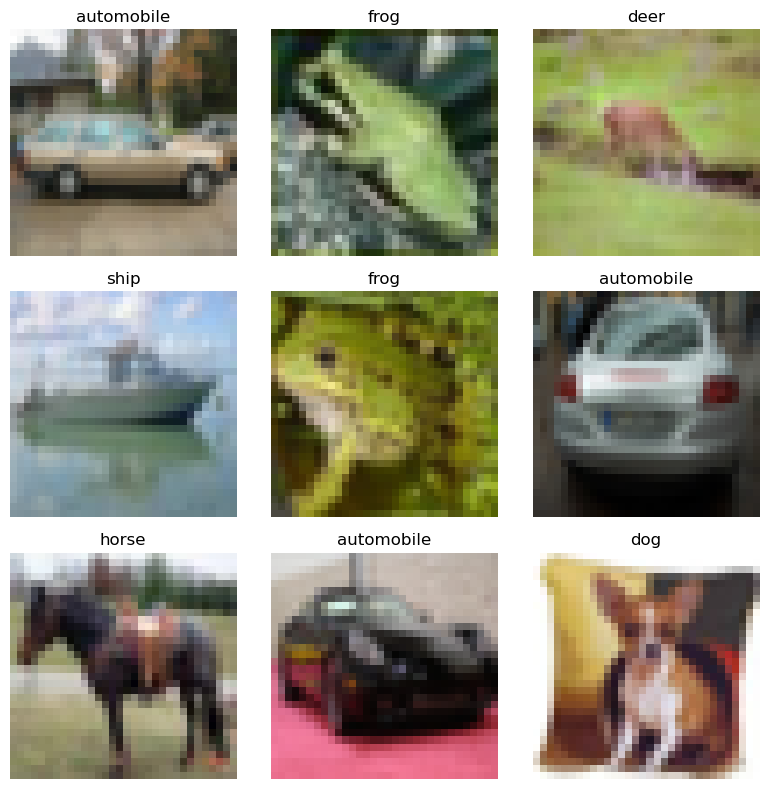

In [75]:
# Load test batch
test_file_path = './cifar-10-batches-py/test_batch'
test_data_dict = unpickle(test_file_path)

# Extract test data and labels
test_data = test_data_dict[b'data']
test_labels = test_data_dict[b'labels']

# Convert test data and labels to numpy arrays
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_labels = np.array(test_labels)

# Print shape of test data and labels
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

# Dimensions of the images
image_shape = train_data.shape[1:]
print("Image dimensions:", image_shape)

# Number of classes
num_classes = len(label_names)
print("Number of classes:", num_classes)

# Display a few random sample images from the training set with class names
def show_random_images(x, y, label_names, num_images=9):
    plt.figure(figsize=(8, 8))
    random_idxs = np.random.choice(x.shape[0], num_images, replace=False)
    for i, idx in enumerate(random_idxs):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[idx].astype('uint8'))
        plt.title(f'{label_names[y[idx]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show random images with labels
show_random_images(train_data, train_labels, label_names)

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [76]:
# Your code here
import numpy as np
from keras.datasets import cifar100
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


# 1. Normalize the images
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# 2. Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels, num_classes=len(label_names))
test_labels_one_hot = to_categorical(test_labels, num_classes=len(label_names))

# 3. Split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    train_data, train_labels_one_hot, test_size=0.2, random_state=42
)

# Print the shapes of the datasets to verify
print("Training Data Shape:", x_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Validation Data Shape:", x_val.shape)
print("Validation Labels Shape:", y_val.shape)
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels_one_hot.shape)

Training Data Shape: (40000, 32, 32, 3)
Training Labels Shape: (40000, 10)
Validation Data Shape: (10000, 32, 32, 3)
Validation Labels Shape: (10000, 10)
Test Data Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000, 10)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a baseline CNN model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# 3rd Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Flatten the output
model.add(Flatten())

# Dense Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization

# Output Layer
model.add(Dense(len(label_names), activation='softmax'))

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> 'categorical_crossentropy' is used for multi-class classification problems.
- <b>Optimizer:</b> Adam optimizer with a learning rate of 0.001. Adam is chosen for its efficiency and effectiveness

In [79]:
from keras import optimizers
import tensorflow as tf

# Your code here
# Compile the model
model.compile(
    optimizer=optimizers.Adam(
        learning_rate=0.001
        ), # Adam optimizer with a learning rate of 0.001. Adam is chosen for its efficiency and effectiveness
    loss='categorical_crossentropy', # 'categorical_crossentropy' is used for multi-class classification problems
    
    metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
)

# Print the model summary to verify
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,362 (2.37 MB)

 Trainable params: 620,362 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [81]:
import tensorflow as tf

class TestAccuracyHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)
        self.model.history.history.setdefault('test_accuracy', []).append(test_acc)

test_accuracy_history = TestAccuracyHistory()

epochs = 15  # You can adjust this number based on your needs


history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)



Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.4611 - loss: 1.4685 - precision: 0.6634 - recall: 0.2249 - val_accuracy: 0.5996 - val_loss: 1.1224 - val_precision: 0.7835 - val_recall: 0.4050
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.5854 - loss: 1.1626 - precision: 0.7552 - recall: 0.4133 - val_accuracy: 0.6485 - val_loss: 0.9996 - val_precision: 0.8055 - val_recall: 0.4953
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 76ms/step - accuracy: 0.6544 - loss: 0.9789 - precision: 0.7872 - recall: 0.5127 - val_accuracy: 0.6979 - val_loss: 0.8558 - val_precision: 0.8050 - val_recall: 0.5829
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 101s 80ms/step - accuracy: 0.6958 - loss: 0.8696 - precision: 0.8102 - recall: 0.5823 - val_accuracy: 0.7191 - val_loss: 0.8041 - val_precision: 0.8222 - val_recall: 0.6142
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 87ms/step - accuracy: 0.7252 - loss: 0.7868 - precision: 0.8222 - recall: 0.6230 - val_accuracy:

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> 0.74 (or 74%)
- <b>Other metric:</b> F1 Score
- <b>Reason for selection:</b> 
-   The F1 score is chosen as it provides a balanced measure of a model's performance by considering both precision and recall. It is particularly useful in classification problems where the dataset may be imbalanced or where we want to ensure a low rate of both false positives and false negatives. The F1 score is more informative than accuracy when class distribution is not uniform or when the cost of false positives and false negatives is different.
- <b>Value of metric:</b> 
    -   Macro F1 Score: 0.74
    -   Weighted F1 Score: 0.74
- <b>Interpretation of metric value:</b> 
    - **Macro F1 Score:** The macro F1 score is an average of the F1 scores calculated for each class independently, without considering class frequency. A macro F1 score of 0.74 indicates that, on average, the model's performance is moderate across all classes, but there is room for improvement. It highlights that the model's ability to balance precision and recall across different classes is somewhat lacking.
    - **Weighted F1 Score:** The weighted F1 score considers the frequency of each class by weighting the F1 scores according to the number of samples in each class. A weighted F1 score of 0.74 suggests that even when accounting for class distribution, the model's overall performance is not optimal. This indicates that the model struggles to maintain a balance between precision and recall, especially in classes with more data points.

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

In [91]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data, test_labels_one_hot, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Predict the classes for the test set
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels_one_hot, axis=1)

# Generate a classification report
report = classification_report(y_true, y_pred_classes, target_names=label_names)
print(report)

Test Accuracy: 0.7357
Test Precision: 0.7801
Test Recall: 0.7016
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
              precision    recall  f1-score   support

    airplane       0.81      0.73      0.77      1000
  automobile       0.89      0.82      0.86      1000
        bird       0.68      0.62      0.65      1000
         cat       0.51      0.59      0.55      1000
        deer       0.71      0.65      0.68      1000
         dog       0.64      0.64      0.64      1000
        frog       0.77      0.82      0.79      1000
       horse       0.76      0.77      0.77      1000
        ship       0.83      0.86      0.85      1000
       truck       0.77      0.85      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



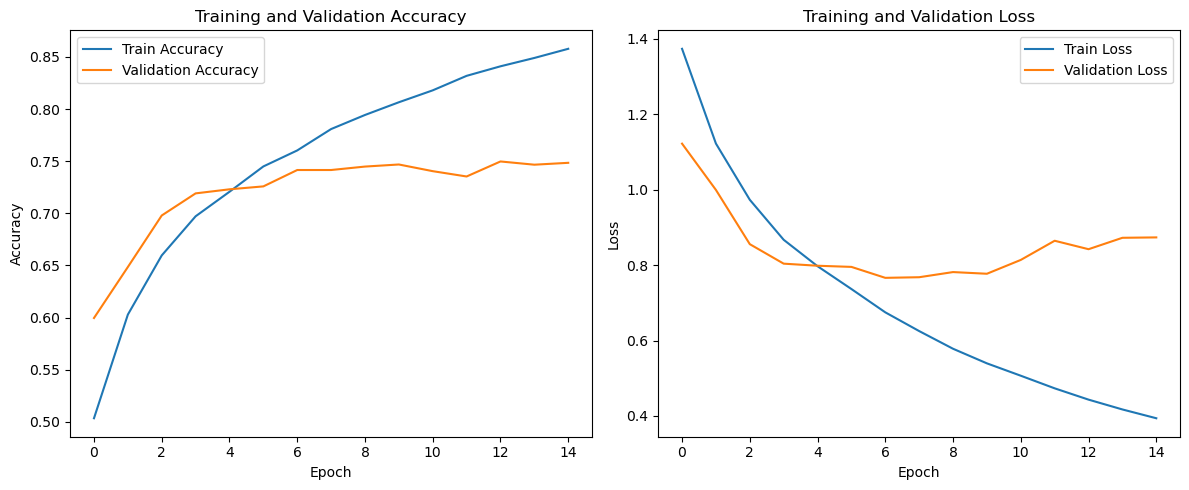

In [83]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

Correctly Classified Image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


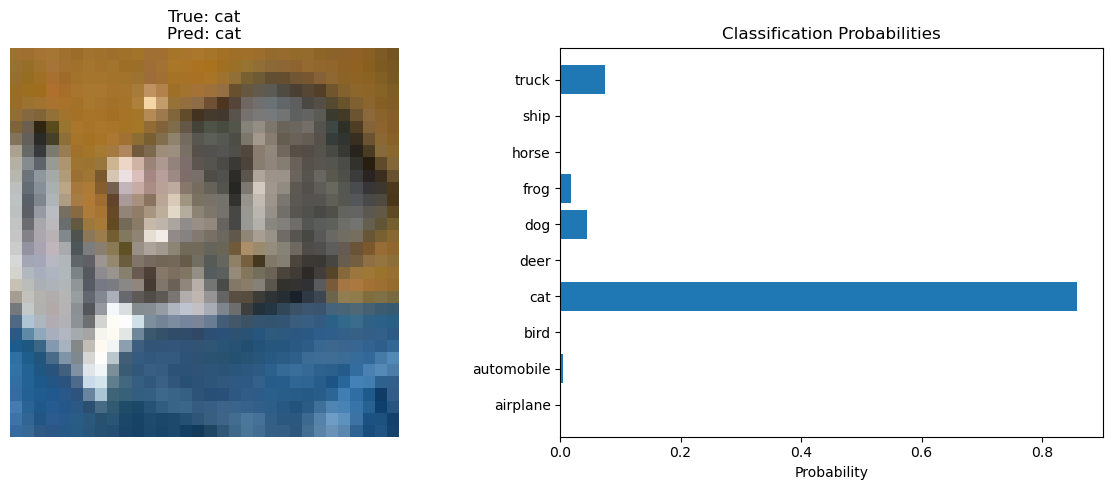

Incorrectly Classified Image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


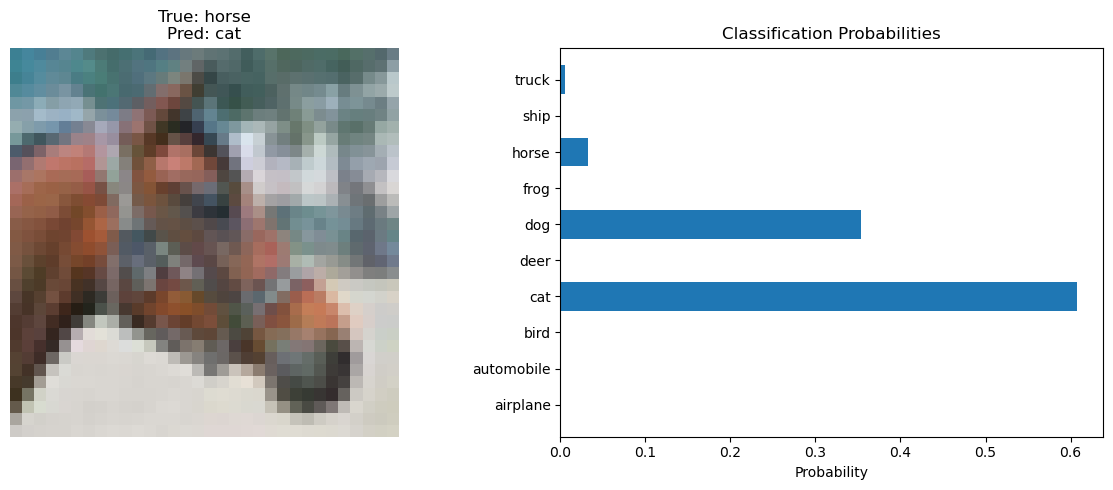

In [92]:
# Get the indices of correctly and incorrectly classified images
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

# Select one correct and one incorrect image
correct_idx = correct_indices[0]
incorrect_idx = incorrect_indices[0]

# Function to plot image and report classification probabilities
def plot_image_with_probabilities(idx, x_test, y_true, y_pred, label_names):
    plt.figure(figsize=(12, 5))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx].astype('float32'))
    true_label = label_names[y_true[idx]]
    predicted_label = label_names[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

    # Plot the classification probabilities
    plt.subplot(1, 2, 2)
    probs = model.predict(np.expand_dims(x_test[idx], axis=0))[0]
    plt.barh(range(len(label_names)), probs)
    plt.yticks(range(len(label_names)), label_names)
    plt.title("Classification Probabilities")
    plt.xlabel("Probability")
    plt.tight_layout()
    plt.show()

# Plot correctly classified image
print("Correctly Classified Image:")
plot_image_with_probabilities(correct_idx, test_data, y_true, y_pred_classes, label_names)

# Plot incorrectly classified image
print("Incorrectly Classified Image:")
plot_image_with_probabilities(incorrect_idx, test_data, y_true, y_pred_classes, label_names)

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from sklearn.metrics import classification_report

def augment(self, image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_crop(image, size=[28, 28, 3])
    image = tf.image.resize(image, [32, 32])
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset
    .shuffle(buffer_size=50000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

model_with_layers = Sequential()

model_with_layers.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model_with_layers.add(BatchNormalization())
model_with_layers.add(tf.keras.layers.ReLU())
model_with_layers.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model_with_layers.add(Conv2D(64, (3, 3), padding='same'))
model_with_layers.add(BatchNormalization())
model_with_layers.add(tf.keras.layers.ReLU())
model_with_layers.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model_with_layers.add(Conv2D(128, (3, 3), padding='same'))
model_with_layers.add(BatchNormalization())
model_with_layers.add(tf.keras.layers.ReLU())
model_with_layers.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model_with_layers.add(Flatten())

model_with_layers.add(Dense(256))
model_with_layers.add(BatchNormalization())
model_with_layers.add(tf.keras.layers.ReLU())
model_with_layers.add(Dropout(0.5))  # Add dropout for regularization

model_with_layers.add(Dense(len(label_names), activation='softmax'))

In [98]:
model_with_layers.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [99]:
epochs = 15

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)


Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 151s 114ms/step - accuracy: 0.7592 - loss: 0.6924 - precision: 0.8363 - recall: 0.6947 - val_accuracy: 0.7279 - val_loss: 0.8003 - val_precision: 0.7898 - val_recall: 0.6789
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 117s 93ms/step - accuracy: 0.7676 - loss: 0.6651 - precision: 0.8392 - recall: 0.6984 - val_accuracy: 0.7455 - val_loss: 0.7694 - val_precision: 0.8187 - val_recall: 0.6894
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 81ms/step - accuracy: 0.7742 - loss: 0.6497 - precision: 0.8443 - recall: 0.7129 - val_accuracy: 0.7291 - val_loss: 0.8081 - val_precision: 0.7912 - val_recall: 0.6735
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.7810 - loss: 0.6322 - precision: 0.8496 - recall: 0.7195 - val_accuracy: 0.7245 - val_loss: 0.7957 - val_precision: 0.7909 - val_recall: 0.6694
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.7829 - loss: 0.6221 - precision: 0.8505 - recall: 0.7220 - val_accur

In [100]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data, test_labels_one_hot, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels_one_hot, axis=1)

generated_report = classification_report(y_true, y_pred_classes, target_names=label_names)
print(generated_report)

Test Accuracy: 0.7880
Test Precision: 0.8293
Test Recall: 0.7505
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
              precision    recall  f1-score   support

    airplane       0.77      0.86      0.81      1000
  automobile       0.94      0.85      0.89      1000
        bird       0.83      0.65      0.73      1000
         cat       0.71      0.55      0.62      1000
        deer       0.82      0.72      0.77      1000
         dog       0.82      0.61      0.70      1000
        frog       0.67      0.94      0.78      1000
       horse       0.76      0.90      0.82      1000
        ship       0.85      0.88      0.87      1000
       truck       0.79      0.93      0.85      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.78     10000
weighted avg       0.80      0.79      0.78     10000



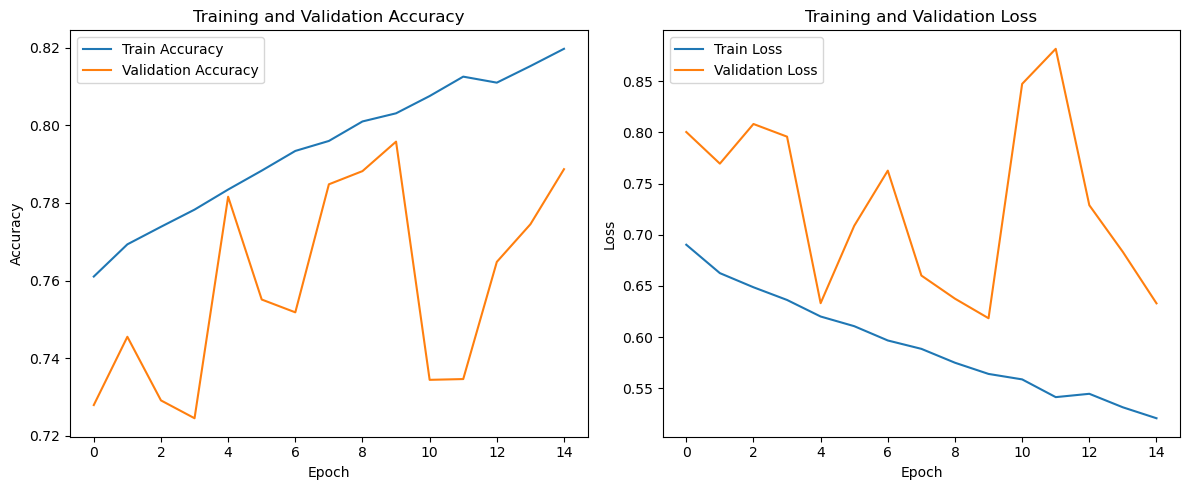

In [101]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

Here is results of dataset evaluation:

Test Accuracy: 0.7880: Correctly classified 78.80% of test images.
Test Precision: 0.8293: 82.93% of predicted classes were correct.
Test Recall: 0.7505: 75.05% of classes were correctly identified.
Metrics (Per-Class):
Airplane: High recall (0.86) but lower precision (0.77).
Automobile: High precision (0.94) and decent recall (0.85).
Bird and Cat: Lower recall (0.65 and 0.55), has indentification issues.
Frog: High recall (0.94) but lower precision (0.67), mostly false positives.
Macro and Weighted Averages:
Macro Avg: Precision 0.80, Recall 0.79, F1-score 0.78.
Weighted Avg: Precision 0.80, Recall 0.79, F1-score 0.78.

The  model performs best on classes like automobiles and ships but has difficulties to indentifies  cats and birds. Some advanced data augmentation techniques can help to improve models

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.